In [2]:
#IMPORT LIBRARIES AND PACKAGES
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import time
from tqdm import tqdm
from random import randint
from time import sleep
import requests
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display


In [2]:
#PREPARATION FOR SELENIUM
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAPL&datatype=csv&outputsize=compact&apikey=9YUPW0WRVEKUFF9L'
df_stock = pd.read_csv(url)
df_stock = df_stock.drop(columns=['volume'])
df_stock.to_csv('stock_data.csv', index=False)


In [136]:
#OPEN DRIVER
driver = webdriver.Chrome()


In [137]:
#GO TO SENATOR TRADING PAGE
url = "https://trendspider.com/markets/congress-trading/"
driver.get(url)
time.sleep(5)


In [138]:
headers = driver.find_elements(By.CSS_SELECTOR, "#main-content table thead th")
header_names = [header.text.strip() for header in headers]


In [139]:
#GET THE INFORMATION FROM THE FIRST PAGE
data = []
rows = driver.find_elements(By.CSS_SELECTOR, "#main-content table tbody tr")

for row in rows:
    cols = row.find_elements(By.TAG_NAME, "td")
    data.append([col.text.strip().replace('\n', ' ') for col in cols])

In [140]:
#GET THE INFORMATION FROM THE FIRST 811 PAGES (ORIGINAL DATASET)
for i in tqdm(range(2, 811)):
    check = f'[aria-label="Current Page, Page {i}."]'
    site = f'[aria-label="Go to page {i}."]'
    while driver.find_elements(By.CSS_SELECTOR, check) == []:
        try:
            driver.find_elements(By.CSS_SELECTOR, site)[0].click()
        except Exception as e:
            time.sleep(randint(10,20)/10)
    

    sleep(randint(10,20)/10)
    rows = driver.find_elements(By.CSS_SELECTOR, "#main-content table tbody tr")
    
    sleep(randint(10,20)/10)
    for row in rows:
        cols = row.find_elements(By.TAG_NAME, "td")
        data.append([col.text.strip().replace('\n', ' ') for col in cols])

100%|██████████| 809/809 [1:58:56<00:00,  8.82s/it]  


In [141]:
#SPLIT COLUMN ABOUT TRANSACTIONS INTO 2 COLUMNS
df = pd.DataFrame(data, columns=header_names)
df[['Type', 'Amount']] = df['Transaction'].str.extract(r'(\w+)\s\$(.*)')
df = df.drop(columns=['Transaction', 'Excess return *'])


In [181]:
#EXPORT AND QUITTING DRIVER
#df.to_csv('senators_trading.csv', index=False) #DISABLED DUE TO POTENTIAL MISSCLICK
driver.quit()


In [21]:

df = pd.read_csv('senators_trading.csv')

UPDATE (BOTH INFORMATION ABOUT ASSETS and ALSO SENATORS_TRADING DATASET)

In [67]:
#LOADING THE CORE DATASET
data_trading = pd.read_csv("senators_trading.csv")

In [68]:
#OPEN DRIVER
driver = webdriver.Chrome()

In [69]:
#GO TO SENATORS TRADING WEBPAGE
url = "https://trendspider.com/markets/congress-trading/"
driver.get(url)
time.sleep(5)


In [70]:
headers = driver.find_elements(By.CSS_SELECTOR, "#main-content table thead th")
header_names = [header.text.strip() for header in headers]

In [71]:
#GET THE DATA FROM THE FIRST PAGE
data = []
rows = driver.find_elements(By.CSS_SELECTOR, "#main-content table tbody tr")

for row in rows:
    cols = row.find_elements(By.TAG_NAME, "td")
    data.append([col.text.strip().replace('\n', ' ') for col in cols])

    


df = pd.DataFrame(data, columns=header_names)
df[['Type', 'Amount']] = df['Transaction'].str.extract(r'(\w+)\s\$(.*)')
df = df.drop(columns=['Transaction', 'Excess return *'])

#SAVE LAST ROW FROM THE TEMPORAL DATASET (WILL BE USED TO CHECK, IF ORIGINAL DATASET CONTAINS THE UPDATED DATA)
last_note = df.iloc[-1]

In [72]:
#CONTINUE TO 2nd ... PAGE. CONITINUE UNTIL THE UPDATED DATASET STARTS TO INTERSECT WITH THE ORIGINAL DATASET
i = 2
while ((data_trading == last_note).all(axis=1)).any() == False:
    data = []
    check = f'[aria-label="Current Page, Page {i}."]'
    site = f'[aria-label="Go to page {i}."]'
    while driver.find_elements(By.CSS_SELECTOR, check) == []:
        try:
            driver.find_elements(By.CSS_SELECTOR, site)[0].click()
        except Exception as e:
            time.sleep(randint(10,20)/10)
    sleep(randint(10,50)/10)
    rows = driver.find_elements(By.CSS_SELECTOR, "#main-content table tbody tr")
    
    for row in rows:
        cols = row.find_elements(By.TAG_NAME, "td")
        data.append([col.text.strip().replace('\n', ' ') for col in cols])

    help_df = pd.DataFrame(data, columns=header_names)
    help_df[['Type', 'Amount']] = help_df['Transaction'].str.extract(r'(\w+)\s\$(.*)')
    help_df = help_df.drop(columns=['Transaction', 'Excess return *'])

    df = pd.concat([df, help_df])


    i += 1
    last_note = df.iloc[-1]

    print(last_note)

driver.quit()

#LEAVE ONLY RECORDS FROM TEMPORAL DATASET, WHICH ARE NOT IN THE ORIGINAL DATASET (CANNOT USE DROP_DUPLICATES DUE TO SIMILARITY BETWEEN SOME TRADES)
mask = ~df.apply(tuple, axis=1).isin(data_trading.apply(tuple, axis=1))
result = df[mask]

#SAVE THE ORIGINAL SYMBOLS FROM THE ORIGINAL CORE DATASET (WHICH CORRESPOND TO THE ORIGINAL DATASET WITH INFO ABOUT STOCKS,ETF,MUTUAL FUNDS...)
original_symbols = data_trading.Stock.apply(lambda x: x.split(" ")[0]).drop_duplicates()

#CONNECT TEMPORAL AND CORE DATASET TO GET UP TO DATE DATASET
data_trading = pd.concat([result, data_trading])

#ADD SYMBOLS TO DATASET
data_trading["ABR"] = data_trading.Stock.apply(lambda x: x.split(" ")[0])


In [77]:
#GET THE SYMBOLS FROM THE TEMPORAL DATASET AND LEAVE ONLY THOSE ETH,STOCKS..., FOR WHICH THE INFORMATION ARE MISSING
result["ABR"] = result.Stock.apply(lambda x: x.split(" ")[0])
result_symbols = result.ABR.drop_duplicates()

additional_symbols = ~result_symbols.isin(original_symbols)


C:\Users\Dario Mikuš\AppData\Local\Temp\ipykernel_17248\80750706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result["ABR"] = result.Stock.apply(lambda x: x.split(" ")[0])


In [78]:
#ITTER THROUGH SYMBOLS WITHOUT INFORMATION TO OBTAIN MISSING INFORMATION FROM YAHOO_FINANCE
#MUST CREATE SEVERAL DATASETS DUE TO DIFFERENCES BETWEEN THE ASSET TYPES
equity = pd.DataFrame()
mutual_fund = pd.DataFrame()
etf = pd.DataFrame()
other = pd.DataFrame()

# ITERATE THROUGH SYMBOLS AND GAIN MISSING INFORMATION
for symbol in tqdm(additional_symbols):
    try:
        stock = yf.Ticker(symbol)
        time.sleep(randint(10,20)/10)

        stock_info = pd.json_normalize(stock.info)

        if 'quoteType' in stock_info.columns:
            quote_type = stock_info['quoteType'][0]
        
    
            if quote_type == 'ETF':
                etf = pd.concat([etf, stock_info], ignore_index=True)
            elif quote_type == 'EQUITY':
                equity = pd.concat([equity, stock_info], ignore_index=True)
            elif quote_type == 'MUTUALFUND':
                mutual_fund = pd.concat([mutual_fund, stock_info], ignore_index=True)
            else:
                other = pd.concat([other, stock_info], ignore_index=True)
        else:
             print(f"quoteType not found for {symbol}. Skipping.")
    except Exception as e:
        continue

100%|██████████| 1/1 [00:00<?, ?it/s]


In [79]:
#ORIGINAL DATASET
info_dataset = pd.read_csv("info_dataset.csv")

#ETF
try:
    data_etf = etf[["quoteType", "symbol", "category", "currency"]]
except:
    data_etf = pd.DataFrame(columns = ["quoteType", "symbol", "category", "currency"])

#EQUITY
try:
    data_equity = equity[["quoteType", "symbol", "country", "industry", "sector", "financialCurrency"]]

    data_equity = data_equity.rename(columns = {"industry" : "category", "financialCurrency" : "currency"})
except:
    data_equity = pd.DataFrame(columns = ["quoteType", "symbol", "country", "industry", "sector", "financialCurrency"])


#MUTUAL FUND
try:
    data_mutual_fund = mutual_fund[["quoteType", "symbol", "currency"]]
except:
    data_mutual_fund = pd.DataFrame(columns = ["quoteType", "symbol", "currency"])

#OTHER
try:
    data_other = other[["quoteType", "symbol", "currency"]]
except:
    data_other = pd.DataFrame(columns = ["quoteType", "symbol", "currency"])

#MERGE ALL DATASETS TO GET UP TO DATE DATASET WITH INFORMATION ABOUT ASSETS
info_dataset = pd.concat([info_dataset, data_etf, data_equity, data_mutual_fund, data_other], ignore_index=True, join='outer')

In [4]:
pd.options.display.max_columns = None


GETTING INFO ABOUT STOCKS_ETF_FUNDS... (CORE DATASET)

In [33]:
#GET THE SYMBOLS, TO BE USED IN YAHOO_FINANCE API
data_trading["ABR"] = data_trading.Stock.apply(lambda x: x.split(" ")[0])

In [36]:
#GAIN UNIQUE SYMBOLS
symbols = data_trading.ABR.drop_duplicates()

In [50]:
#CREATE EMPTY DATASETS DUE TO DIFFERENCES BETWEEN INFORMATION PROVIDED FOR DIFFERENT ASSETS
equity = pd.DataFrame()
mutual_fund = pd.DataFrame()
etf = pd.DataFrame()
other = pd.DataFrame()

In [ ]:
# ITERATE THROUGH ALL SYMBOLS
for symbol in tqdm(symbols):
    try:
        stock = yf.Ticker(symbol)
        time.sleep(randint(10,20)/10)

        stock_info = pd.json_normalize(stock.info)

        if 'quoteType' in stock_info.columns:
            quote_type = stock_info['quoteType'][0]
        
    
            if quote_type == 'ETF':
                etf = pd.concat([etf, stock_info], ignore_index=True)
            elif quote_type == 'EQUITY':
                equity = pd.concat([equity, stock_info], ignore_index=True)
            elif quote_type == 'MUTUALFUND':
                mutual_fund = pd.concat([mutual_fund, stock_info], ignore_index=True)
            else:
                other = pd.concat([other, stock_info], ignore_index=True)
        else:
             print(f"quoteType not found for {symbol}. Skipping.")
    except Exception as e:
        continue

In [66]:
#EXPORT (NO LONGER USED)
#other.to_csv("other.csv")
#etf.to_csv("etf.csv")
#equity.to_csv("equity.csv")
#mutual_fund.to_csv("mutual_fund.csv")

In [2]:
#LOAD (NO LONGER USED DUE TO CREATION OF OVERAL DATASET)
other = pd.read_csv("other.csv")
equity = pd.read_csv("equity.csv")
mutual_fund = pd.read_csv("mutual_fund.csv")
etf = pd.read_csv("etf.csv")

In [14]:
#INFORMATIVE DATA FOR ETF
data_etf = etf[["quoteType", "symbol", "category", "currency"]]

In [17]:
#INFORMATIVE DATA FOR EQUITY
data_equity = equity[["quoteType", "symbol", "country", "industry", "sector", "financialCurrency"]]

data_equity = data_equity.rename(columns = {"industry" : "category", "financialCurrency" : "currency"})

In [ ]:
#INFORMATIVE DATA FOR MUTUAL FUNDS
data_mutual_fund = mutual_fund[["quoteType", "symbol", "currency"]]

In [ ]:
#INFORMATIVE DATA FOR OTHER TYPES (INDEX, NONE)
data_other = other[["quoteType", "symbol", "currency"]]

In [20]:
#CREATE COMPLET INFO DATASET
info_dataset = pd.DataFrame(columns= ["symbol", "quoteType", "country", "category", "sector", "currency", "category"])

info_dataset = pd.concat([data_etf, data_equity, data_mutual_fund, data_other], ignore_index=True, join='outer')

In [ ]:
#EXPORT
info_dataset.to_csv("info_dataset.csv")

In [80]:
info_dataset = pd.read_csv("info_dataset.csv")

DESCRIPTIVE GRAPHS AND ANALYSIS

DATASET PREPARATION

In [30]:
#LOADING THE CORE DATASET
data_trading = pd.read_csv("senators_trading.csv")

In [25]:
info_trading = pd.read_csv("info_dataset.csv")
info_trading = info_trading.drop_duplicates(subset = "symbol")

In [31]:
data_trading["Party"] = data_trading["Politician"].str.split(" ").str[-3]
data_trading["House"] = data_trading["Politician"].str.split(" ").str[-1]
data_trading["Politician"] = data_trading["Politician"].apply(lambda x: " ".join(x.split(" ")[:-3]))

data_trading["Traded"] = pd.to_datetime(data_trading["Traded"], format="%b %d, %Y")
data_trading["Traded"] = data_trading["Traded"].dt.strftime("%Y-%m-%d")

data_trading["Filed"] = pd.to_datetime(data_trading["Filed"], format="%b %d, %Y")
data_trading["Filed"] = data_trading["Filed"].dt.strftime("%Y-%m-%d")

data_trading["ABR"] = data_trading["Stock"].apply(lambda x: x.split(" ")[0])

In [32]:
data_trading["min"] = data_trading["Amount"].str.split(" - \\$").str[0]
data_trading["max"] = data_trading["Amount"].str.split(" - \\$").str[1]

data_trading["min"] = data_trading["min"].str.replace(",", "")
data_trading["max"] = data_trading["max"].str.replace(",", "")


data_trading["min"] = pd.to_numeric(data_trading["min"], errors="coerce")
data_trading["max"] = pd.to_numeric(data_trading["max"], errors="coerce")

data_trading["avg_invested"] = np.where(
    data_trading["Type"] == "Purchase",
    (data_trading["min"] + data_trading["max"]) / 2,
    -(data_trading["min"] + data_trading["max"]) / 2
)

In [111]:
data_trading = data_trading.applymap(lambda x: x.strip() if isinstance(x, str) else x)

C:\Users\Dario Mikuš\AppData\Local\Temp\ipykernel_13036\381786573.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_trading = data_trading.applymap(lambda x: x.strip() if isinstance(x, str) else x)


GRAPH OF ACTIVE INVESTMENT IN TIME

In [238]:
def get_the_color(of_what):
    if of_what == "R":
        color = "red"
    elif of_what == "D":
        color = "blue"

    else:
        get_party = data_trading[data_trading["Politician"] == of_what].iloc[0]["Party"]
        if get_party == "R":
            color = "red"
        elif get_party == "D":
            color = "blue"
    
    return color

In [244]:
def grouping_for_graph(by_what, what_to_display):
    data_trading_in_time = data_trading[[by_what, "Traded", "avg_invested"]]

    data_trading_in_time = data_trading_in_time.groupby([by_what, "Traded"]).sum()

    data_trading_in_time.reset_index(inplace=True)

    data_trading_in_time["cumulative_invested"] = (
        data_trading_in_time.sort_values(by=[by_what, "Traded"])  # Sort by Politician and Traded
        .groupby(by_what)  # Group by Politician
        .apply(lambda group: group["avg_invested"].cumsum())  # Apply cumsum within each group
        .reset_index(drop=True)  # Reset index to maintain original order
    )


    help_df = data_trading_in_time[data_trading_in_time[by_what] == what_to_display]

    help_df = help_df.set_index("Traded")

    
    color_of_graph = get_the_color(what_to_display)


    plt.plot(help_df.index, help_df['cumulative_invested'], color = color_of_graph)
    plt.xticks([help_df.index[0], help_df.index[-1]])
    plt.show()

C:\Users\Dario Mikuš\AppData\Local\Temp\ipykernel_13036\1633311999.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group["avg_invested"].cumsum())  # Apply cumsum within each group


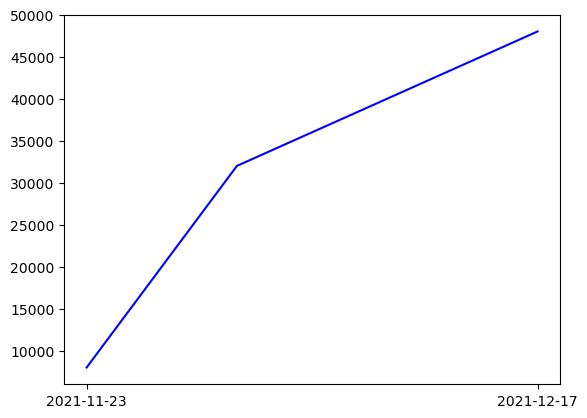

In [246]:
grouping_for_graph("Politician", "A. Donald McEachin")

TABLE OF INFORMATION ABOUT TRADERS

In [9]:
data_trading["ABR"] = data_trading["Stock"].apply(lambda x: x.split(" ")[0])

In [34]:
data_trading = data_trading.merge(info_trading, how="left", left_on="ABR", right_on="symbol")

In [56]:
#TOTAL INVESTED
total_purchased = data_trading[data_trading["Type"] == "Purchase"].groupby("Politician")["avg_invested"].sum().reset_index()

#Total SOLD
total_sold = data_trading[data_trading["Type"] == "Sale"].groupby("Politician")["avg_invested"].sum().reset_index()

#TOTAL PURCHASED PER SECOTR
total_purchased_sector = data_trading[data_trading["Type"] == "Purchase"].groupby(["Politician", "category"])["avg_invested"].sum().reset_index()

#TOTAL SOLD PER SECOTR
total_sold_sector = data_trading[data_trading["Type"] == "Sale"].groupby(["Politician", "category"])["avg_invested"].sum().reset_index()

#TOTAL PURCHASED PER TYPE
total_purchased_type = data_trading[data_trading["Type"] == "Purchase"].groupby(["Politician", "quoteType"])["avg_invested"].sum().reset_index()

#TOTAL SOLD PER TYPE
total_sold_type = data_trading[data_trading["Type"] == "Sale"].groupby(["Politician", "quoteType"])["avg_invested"].sum().reset_index()

#TOTAL PURCHASED PER CURRENCY
total_purchased_currency = data_trading[data_trading["Type"] == "Purchase"].groupby(["Politician", "currency"])["avg_invested"].sum().reset_index()

#TOTAL SOLD PER CURRENCY
total_sold_currency = data_trading[data_trading["Type"] == "Sale"].groupby(["Politician", "currency"])["avg_invested"].sum().reset_index()

#TOTAL PURCHASED PER COUNTRY
total_purchased_country = data_trading[data_trading["Type"] == "Purchase"].groupby(["Politician", "country"])["avg_invested"].sum().reset_index()

#TOTAL SOLD PER COUNTRY
total_sold_country = data_trading[data_trading["Type"] == "Sale"].groupby(["Politician", "country"])["avg_invested"].sum().reset_index()

In [ ]:
def pie_chart(df, politician):

    help_df = df[df["Politician"] == politician]

    labels = help_df.iloc[:, 1]

    plt.figure(figsize=(7, 7))
    plt.pie(help_df['avg_invested'], labels=labels, autopct='%1.1f%%', startangle=0)

    # Add title
    plt.title("Average Investment by Politician")

    # Display the pie chart
    plt.show()  

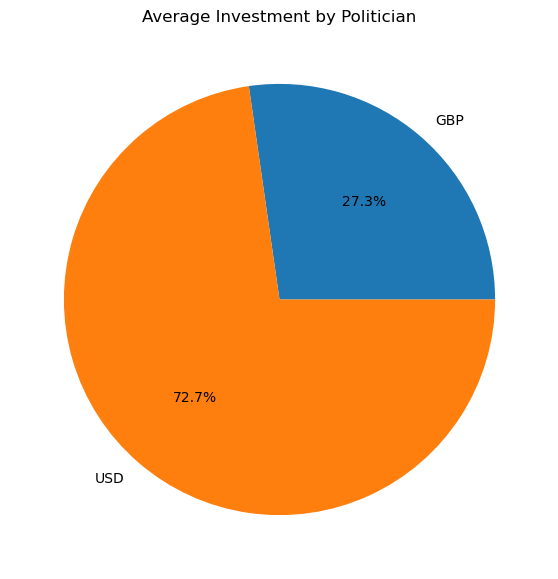

In [75]:
pie_chart(total_purchased_currency, "Adam Kinzinger")